<a href="https://colab.research.google.com/github/NINE9-9-9/Flood-Detection/blob/main/model_train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

import os

from google.colab import drive
drive.mount('/content/drive')
!pip install git+https://github.com/spaceml-org/ml4floods#egg=ml4floods
!pip install wandb

import wandb
wandb.login()


from ml4floods.models import dataset_setup


# Unzip the data
path_to_dataset_folder = "/content/drive/My Drive/Final"
dataset_folder = os.path.join(path_to_dataset_folder, "worldfloods_v1_0_sample")

dataset_setup.validate_worldfloods_data(dataset_folder)

from ml4floods.models.config_setup import get_default_config
import pkg_resources

config_fp = pkg_resources.resource_filename("ml4floods","models/configurations/worldfloods_template.json")

config = get_default_config(config_fp)
config["model_params"]["max_tile_size"] = 1024
from pytorch_lightning import seed_everything
# Seed
seed_everything(config.seed)

config.data_params.batch_size = 16 # control this depending on the space on your GPU!
config.data_params.loader_type = 'local'
config.data_params.path_to_splits = dataset_folder # local folder to download the data
config.data_params.train_test_split_file = None

print(config)
# If files are not in config.data_params.path_to_splits this will trigger the download of the products.
%run '/content/drive/MyDrive/Final/load_data.ipynb'
dataset = get_dataset(config.data_params)
train_dl = dataset.train_dataloader()
val_dl = dataset.val_dataloader()
test_dl = dataset.test_dataloader()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
  Cloning https://github.com/spaceml-org/ml4floods to /tmp/pip-install-uad1beq2/ml4floods_6544ce075b504f12a7499064b3ce292c
  Running command git clone --filter=blob:none --quiet https://github.com/spaceml-org/ml4floods /tmp/pip-install-uad1beq2/ml4floods_6544ce075b504f12a7499064b3ce292c
  Resolved https://github.com/spaceml-org/ml4floods to commit 24763f3e344d0a682ba250dce898f633ca56aee4
  Preparing metadata (setup.py) ... done


wandb: Currently logged in as: qq852447 (nine-99). Use `wandb login --relogin` to force relogin
INFO:lightning_fabric.utilities.seed:Global seed set to 12


Data downloaded follows the expected format
{'experiment_name': 'worldfloods_demo_test', 'seed': 12, 'model_params': {'model_folder': 'gs://ml4cc_data_lake/0_DEV/2_Mart/2_MLModelMart', 'model_version': 'v1', 'hyperparameters': {'max_tile_size': 256, 'metric_monitor': 'val_dice_loss', 'channel_configuration': 'all', 'label_names': ['land', 'water', 'cloud'], 'weight_per_class': [1.93445299, 36.60054169, 2.19400729], 'model_type': 'linear', 'num_classes': 3, 'max_epochs': 10, 'val_every': 1, 'lr': 0.0001, 'lr_decay': 0.5, 'lr_patience': 2, 'early_stopping_patience': 4, 'num_channels': 13}, 'train': True, 'test': True, 'max_tile_size': 1024}, 'data_params': {'loader_type': 'local', 'num_workers': 4, 'filter_windows': {'version': 'v1', 'threshold_clouds': 0.5, 'apply': False}, 'download': {'train': True, 'val': True, 'test': True}, 'bucket_id': 'ml4cc_data_lake', 'path_to_splits': '/content/drive/My Drive/Final/worldfloods_v1_0_sample', 'train_test_split_file': None, 'input_folder': 'S2', 

In [2]:
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import WandbLogger


logger = WandbLogger(project="worldfloods", name="fcn_resnet50")

# !pip install cloud-tpu-client==0.10 https://storage.googleapis.com/tpu-pytorch/wheels/torch_xla-1.8-cp37-cp37m-linux_x86_64.whl

checkpoint_callback = ModelCheckpoint(
    dirpath='/content/drive/My Drive/Final/FCN_checkpoint/resnet50',
    # dirpath='/content/drive/My Drive/Final/deeplabv3_checkpoint/new',
    # dirpath='/content/drive/My Drive/Final/PSPNet_checkpoint/new',
    # dirpath='/content/drive/My Drive/Final/SegNet_checkpoint/new',
    # dirpath='/content/drive/My Drive/Final/SegFormer_checkpoint/new',
    # dirpath='/content/drive/My Drive/Final/UNet_checkpoint/library',
    # dirpath='/content/drive/My Drive/Final/UNetPlus_checkpoint/new3',
    save_top_k=-1,
    filename='{epoch}',
    monitor='val_loss',
    mode='min',
    every_n_epochs=10,  # Save every 20 epochs
    verbose=True
)

# config.gpus = '0'  # which gpu to use
# config.gpus = None # to not use GPU

config.model_params.hyperparameters.max_epochs = 20 # train for maximum 4 epochs

trainer = Trainer(
    fast_dev_run=False,
    accelerator="cuda",
    accumulate_grad_batches=1,
    gradient_clip_val=0.0,
    callbacks=[checkpoint_callback],
    check_val_every_n_epoch=1,
    max_epochs=20,
    logger=logger
)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [3]:
# import sys
# sys.path.append('/content/drive/MyDrive/Final/')
%run '/content/drive/MyDrive/Final/FCN.ipynb'
# config.model_params
from ml4floods.models.model_setup import get_model

# config.model_params.model_folder = "models"
# os.makedirs("models", exist_ok=True)
# config.model_params.test = False
# config.model_params.train = True
# config.model_params.hyperparameters.model_type = "unet" # Currently implemented: simplecnn, unet, linear
# model = get_model(config.model_params)

model = FCN2(3).cuda()
# model = DeepLabV3().cuda()
# model = PSPNet(13, 3).cuda()
# model = SegNet(3).cuda()
# model = SegFormer(13, 3).cuda()
# model = UNet(13, 3).cuda()
# model = UNetPlus(13, 3)
# model = PSPDeep(13,3)
# model = SegFormer(13, 3).load_from_checkpoint(checkpoint_path="/content/drive/My Drive/Final/SegFormer_checkpoint/epoch=19.ckpt").cuda()
# model = DeepLabV3().load_from_checkpoint(checkpoint_path="/content/drive/My Drive/Final/deeplabv3_checkpoint/new/epoch=19.ckpt").cuda()
# model = FCN().load_from_checkpoint(checkpoint_path="/content/drive/My Drive/Final/FCN_checkpoint/epoch=19.ckpt")
model = model.cuda()
model

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FCN_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=FCN_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


FCN2(
  (model): FCN(
    (backbone): IntermediateLayerGetter(
      (conv1): Conv2d(13, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReL

In [4]:
trainer.fit(model, dataset)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type | Params
-------------------------------
0 | model | FCN  | 35.3 M
-------------------------------
35.3 M    Trainable params
0         Non-trainable params
35.3 M    Total params
141.377   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:438: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 9, global step 3940: 'val_loss' reached 0.78282 (best 0.78282), saving model to '/content/drive/My Drive/Final/FCN_checkpoint/resnet50/epoch=9.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 19, global step 7880: 'val_loss' reached 0.76329 (best 0.76329), saving model to '/content/drive/My Drive/Final/FCN_checkpoint/resnet50/epoch=19.ckpt' as top 2
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.


Shape of logits: torch.Size([16, 3, 256, 256])
Shape of probs: torch.Size([16, 3, 256, 256])
Shape of prediction: torch.Size([16, 256, 256])


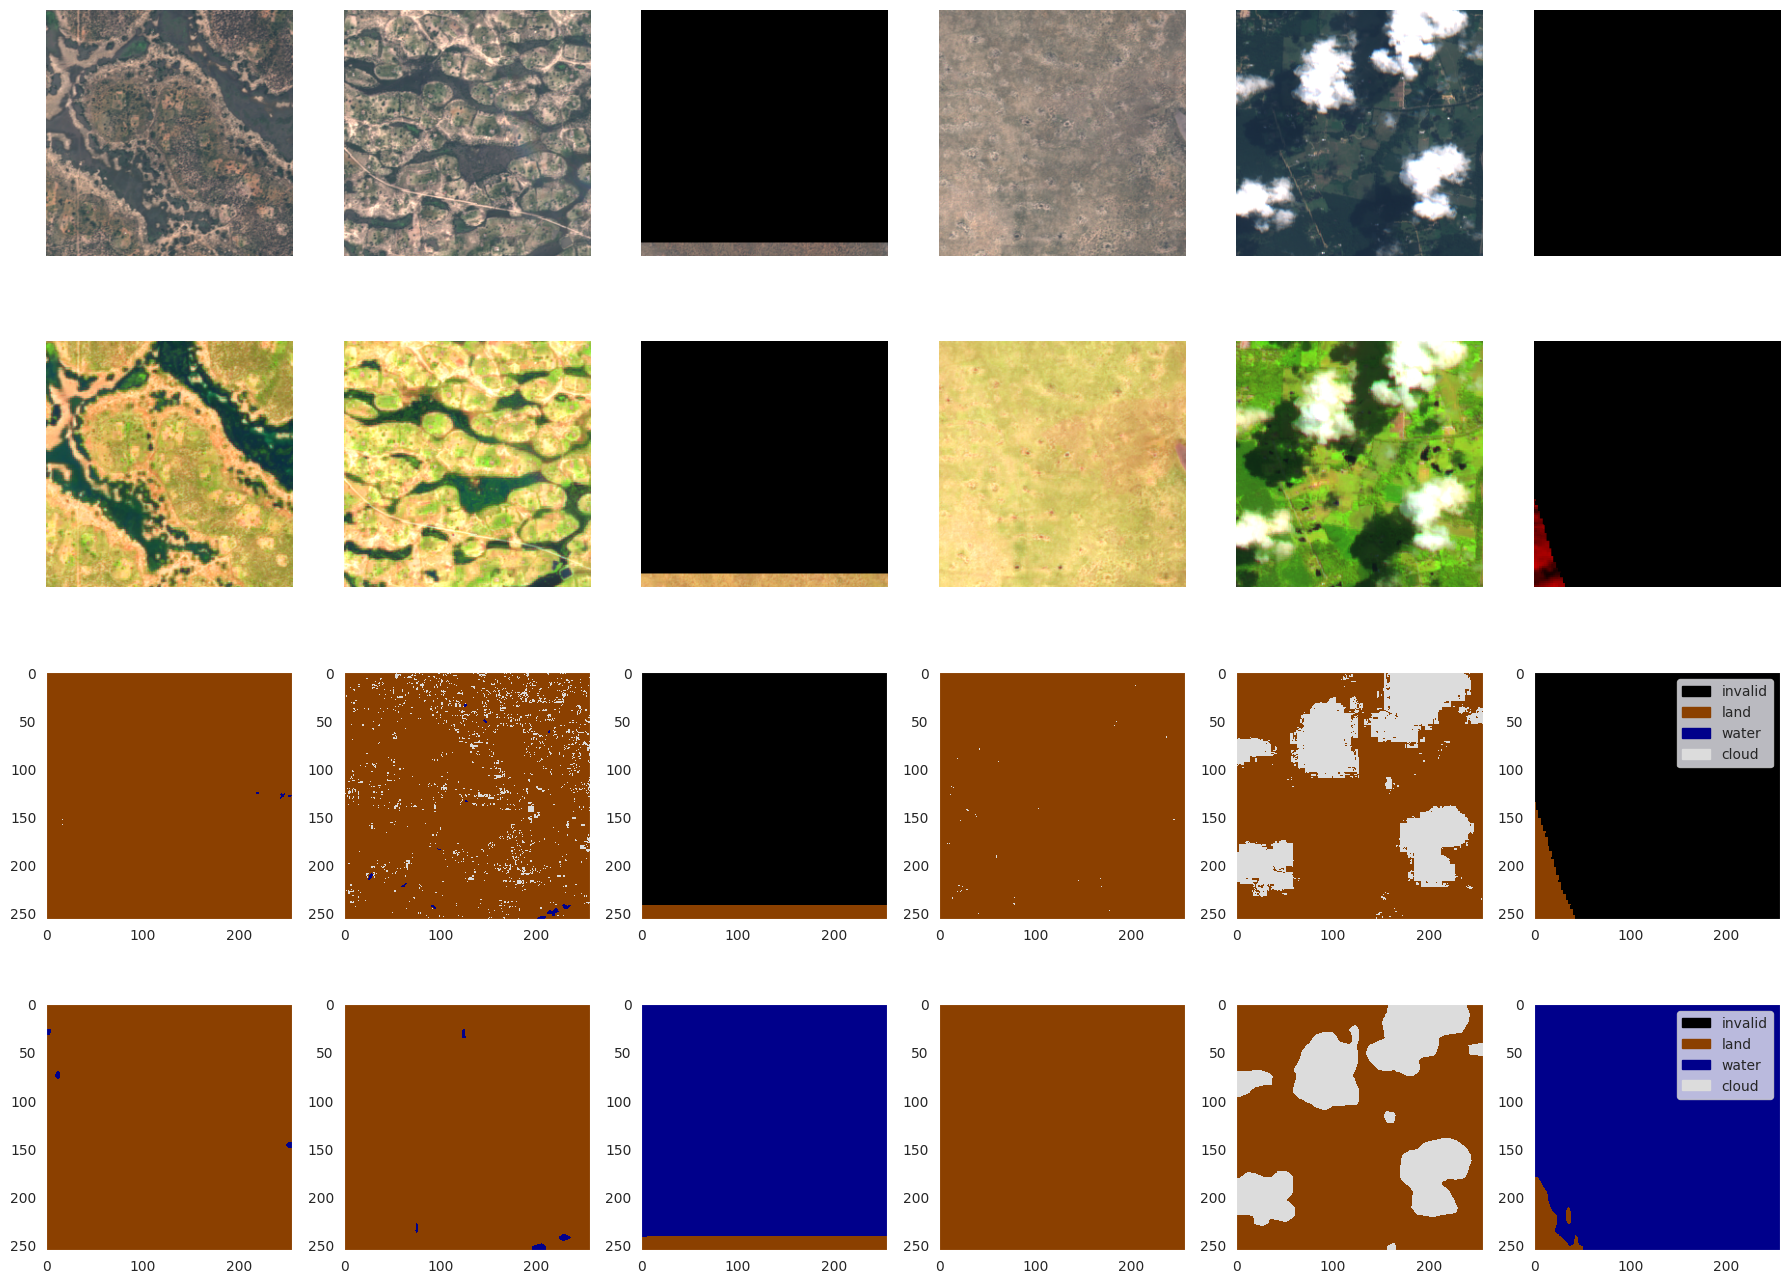

In [7]:
from ml4floods.models import worldfloods_model
import matplotlib.pyplot as plt
import torch

train_dl_iter = iter(train_dl)
batch = next(train_dl_iter)

logits = model(batch["image"].to(model.device))
print(f"Shape of logits: {logits.shape}")
probs = torch.softmax(logits, dim=1)
print(f"Shape of probs: {probs.shape}")
prediction = torch.argmax(probs, dim=1).long().cpu()
print(f"Shape of prediction: {prediction.shape}")
n_images=6
# print(prediction[:n_images] + 1)
fig, axs = plt.subplots(4, n_images, figsize=(18,14),tight_layout=True)
worldfloods_model.plot_batch(batch["image"][:n_images],axs=axs[0],max_clip_val=3500.)
worldfloods_model.plot_batch(batch["image"][:n_images],bands_show=["B11","B8", "B4"],
                             axs=axs[1],max_clip_val=4500.)
worldfloods_model.plot_batch_output_v1(batch["mask"][:n_images, 0],axs=axs[2], show_axis=True)
worldfloods_model.plot_batch_output_v1(prediction[:n_images] + 1,axs=axs[3], show_axis=True)

for ax in axs.ravel():
    ax.grid(False)

Getting model inference function


100%|██████████| 11/11 [02:03<00:00, 11.27s/it]


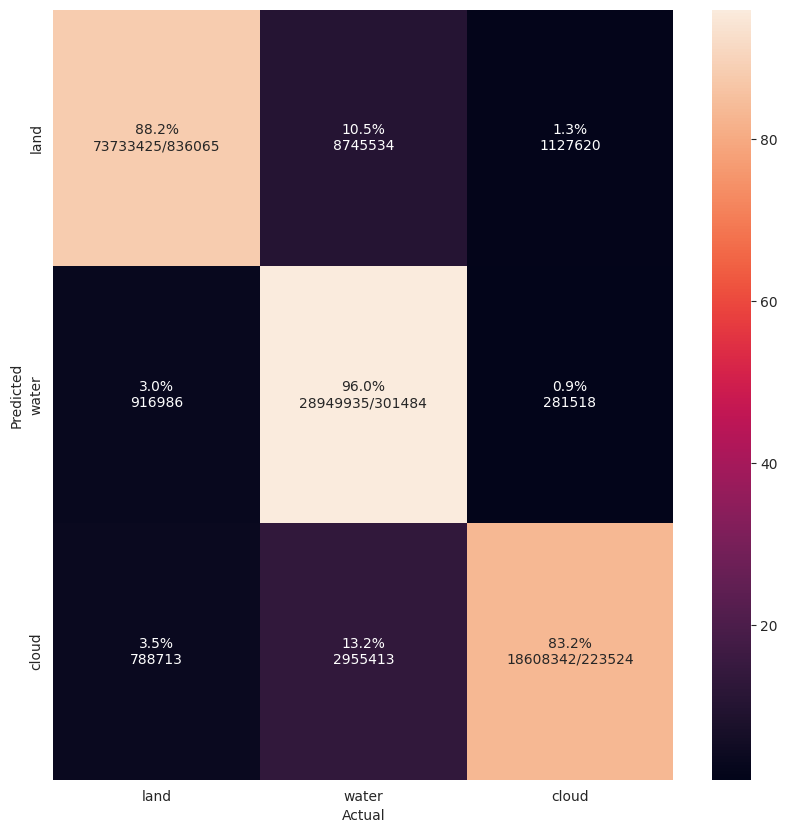

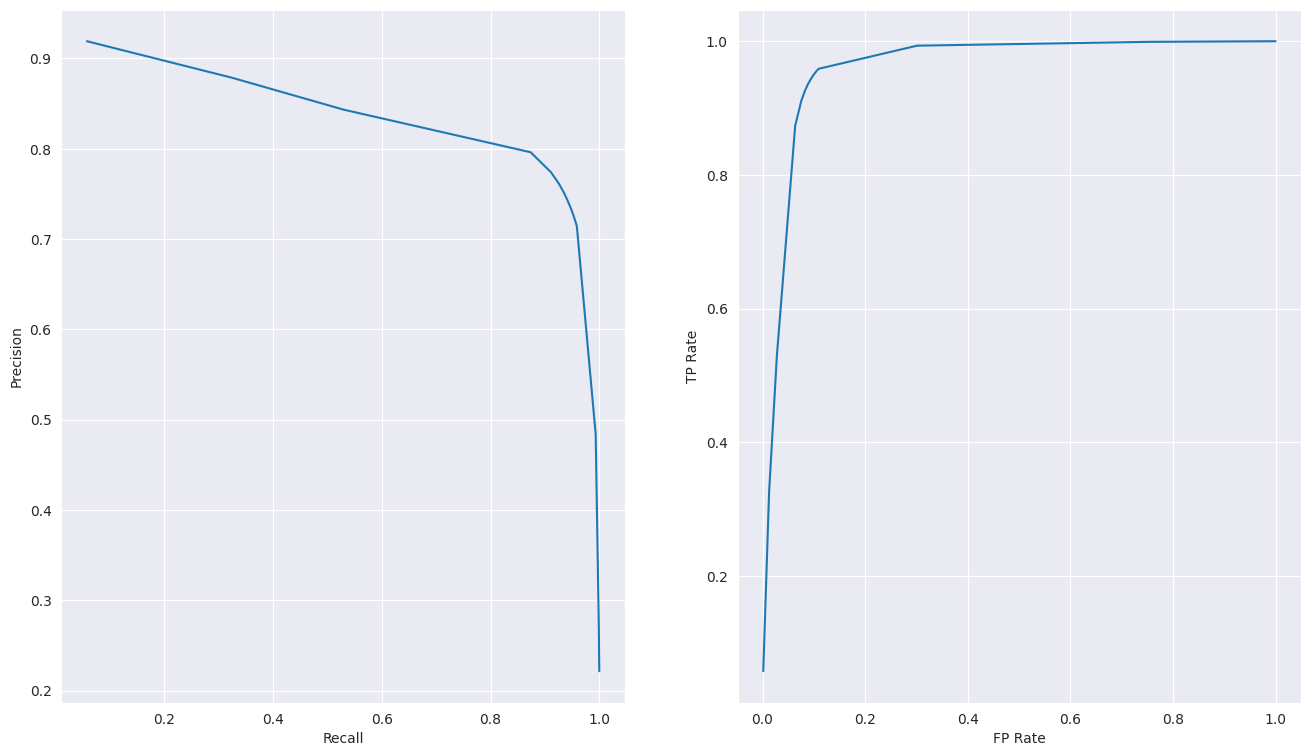

Per Class IOU {
    "cloud": 0.7831264435578041,
    "land": 0.8642768277738623,
    "water": 0.691764868426067
}


In [8]:
import torch
import numpy as np
from ml4floods.models.utils import metrics
from ml4floods.models.model_setup import get_model_inference_function
import pandas as pd

config.model_params.max_tile_size = 1024
model.eval()
model = model.cuda()
inference_function = get_model_inference_function(model, config, apply_normalization=False,
                                                  activation="softmax",
                                                  device=torch.device("cuda"))

# Otherwise fails when reading test dataset from remote bucket
# torch.set_num_threads(1)

thresholds_water = [0,1e-3,1e-2]+np.arange(0.5,.96,.05).tolist() + [.99,.995,.999]

mets = metrics.compute_metrics(
    test_dl,
    inference_function,
    thresholds_water=thresholds_water,
    convert_targets=False,
    plot=False)

label_names = ["land", "water", "cloud"]
metrics.plot_metrics(mets, label_names)